# Sentiment Analysis with GloVe 
In this lab, we demonstrate how to use GloVe word vector representations in Sentiment Analysis. 

The data set is [Sentiment140](http://www.sentiment140.com/), which is a collection of 1.6 million tweets that have been tagged as either positive or negative. It is also available in [Kaggle](https://www.kaggle.com/kazanova/sentiment140) or [Digital Ocean](https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip).

GloVe is available for download from https://nlp.stanford.edu/projects/glove/. We use "100 dimension" version in "glove.6B.zip".

## Download Dataset

In [1]:
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip -P data
!unzip -n -d data data/training.1600000.processed.noemoticon.csv.zip

--2021-02-17 21:08:13--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85088192 (81M) [application/zip]
Saving to: ‘data/training.1600000.processed.noemoticon.csv.zip’

training.1600000.pr 100%[===================>]  81.15M  98.9MB/s    in 0.8s    

2021-02-17 21:08:14 (98.9 MB/s) - ‘data/training.1600000.processed.noemoticon.csv.zip’ saved [85088192/85088192]

Archive:  data/training.1600000.processed.noemoticon.csv.zip
  inflating: data/training.1600000.processed.noemoticon.csv  


## Data Cleaning (Optional)
We can choose to clean the Sentiment140 tweet dataset, but not necessary.

If you like, make sure to save "df" as a "csv" file for later work.

### Read Data

In [2]:
import pandas as pd

df = pd.read_csv("data/training.1600000.processed.noemoticon.csv",
                names=['polarity', 'id', 'date', 'query', 'user', 'text'],
                encoding='latin-1')
df.head()

,polarity,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Update Polarity

Right now the `polarity` column in data is `0` for negative and `4` for positive.

In [3]:
df.polarity.value_counts()

4    800000
0    800000
Name: polarity, dtype: int64

We can change that to `0` and `1` to make things a little more reasonably readable.

In [4]:
df.polarity.value_counts()

4    800000
0    800000
Name: polarity, dtype: int64

### Remove Unneeded Columns

We don't need all those columns! Let's get rid of the ones that won't affect the sentiment.

In [5]:
df = df.drop(columns=['id', 'date', 'query', 'user'])
df.head()

,polarity,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


### Sample

If you like, you can choose to make the filesize a little smaller and pandas a little happier, by knocking this down to 500,000 tweets. 

In [ ]:
df = df.sample(n=500000)
df.polarity.value_counts()

df.to_csv("data/sentiment140-subset.csv", index=False)

## Data Processing

First, we clean the dataset to remove LATIN1 encoding to make it easier for Python CSV reader.

In [16]:
!iconv -f latin1 -t UTF8 data/training.1600000.processed.noemoticon.csv -o data/training_cleaned.csv

Next we create corpus:

In [27]:
import json
import tensorflow as tf
import csv
import random
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

In [32]:
corpus = []
num_sentences = 0

with open("data/training_cleaned.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        
      # Create list items where the first item is the text, found in row[5],
      # and the second is the label. 
      # Note that the label is a '0' or a '4' in the text.
      # When it's the former, make your label to be 0, otherwise 1. 
      # Keep a count of the number of sentences in num_sentences
        list_item=[]
        list_item.append(row[5])
        if row[0] == "0":
          list_item.append(0)
        else:
          list_item.append(1)
        
        num_sentences = num_sentences + 1
        corpus.append(list_item)


In [34]:
print(num_sentences)
print(len(corpus))
print(corpus[2])

1600000
1600000
['@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds', 0]


## Tokenization

Tokenization comes from the training for the word appearences in the dataset. It will be used to encode sentence words as numbers.

In [35]:
# YH: 
# Difine your dataset size here. 
# Experiment using smaller values (i.e. 16000), 
# but don't forget to train on at least 160000 to see the best effects.
training_size=160000 
sentences=[]
labels=[]
random.shuffle(corpus)

# YH: Take the first 'training_size' many data as training set.
for x in range(training_size):
    sentences.append(corpus[x][0]) 
    labels.append(corpus[x][1])

# YH: Use training set to fit the encoding for the vocabulary.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

Parameters for encoding:

In [ ]:
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
test_portion=.1

In [36]:
word_index = tokenizer.word_index
vocab_size=len(word_index)

# YH: Encode the training set.
sequences = tokenizer.texts_to_sequences(sentences)

# YH: Pad sentences to have a uniform length.
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences     = padded[0:training_size-split]
training_sequences = padded[training_size-split:] 
test_labels        = labels[0:training_size-split] 
training_labels    = labels[training_size-split:] 

In [37]:
# See, "I" should be the most frequent word appearing...
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

138457
1


## Download GloVe

In [45]:
!wget --no-check-certificate \
    https://resources.oreilly.com/conferences/natural-language-processing-with-deep-learning/raw/fa9a1c9182077fe1306ac07776366ad2de7489f6/data/glove.6B.100d.txt?inline=false \
    -O /tmp/glove.6B.100d.txt

--2021-02-18 00:18:43--  https://resources.oreilly.com/conferences/natural-language-processing-with-deep-learning/raw/fa9a1c9182077fe1306ac07776366ad2de7489f6/data/glove.6B.100d.txt?inline=false
Resolving resources.oreilly.com (resources.oreilly.com)... 199.27.144.212, 199.27.144.213
Connecting to resources.oreilly.com (resources.oreilly.com)|199.27.144.212|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  7.62MB/s    in 41s     

2021-02-18 00:19:25 (8.03 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



## Word Embeddings
Next we convert GloVe word vector representations to word embeddings.

In [46]:
embeddings_index = {};

# YH: Obtain the GloVe embedding matrix for words, and save in set 'embeddings_index'.
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

# YH: Initiate a matrix as 'embeddings_matrix'.
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));

# YH: Convert the set 'embeddings_index' into 'embeddings_matrix'.
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [ ]:
print(len(embeddings_matrix))
# Expected Output
# 138859

138543


In [47]:
print(embeddings_matrix.shape)

(138458, 100)


## Construct Model

In [66]:
model = tf.keras.Sequential([
    # YH: tf.keras.layers.Embedding(input_dim, output_dim,...)
    # YH: input_dim 	Integer. Size of the vocabulary, i.e. maximum integer index + 1.
    #     output_dim 	Integer. Dimension of the dense embedding. 
    # YH: What I think is that the embedding vector for each word as raw input data and training for coefficients in this layer.
    #     If not using embeddings_matrix, then we use above tokenization for encoding word into digits which used as raw input data
    # YH: Note the setting of 'trainable=False' which says would not change Embedding Matrix in the training.
    #     During the training, it only fits other layer parameters and remain this layer unchanged.
    #     Remember, Embedding Matrix is a co-product of the training.
    #     Will it need to evolve or using transfer learning, it depends.
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    # experiment with combining different types, such as convolutions and LSTMs
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 16, 100)           13845800  
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 256)               234496    
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 14,113,321
Trainable params: 267,521
Non-trainable params: 13,845,800
_________________________________________________________________


In [67]:
num_epochs = 20

training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")


Epoch 1/20
500/500 - 16s - loss: 0.6000 - accuracy: 0.6741 - val_loss: 0.5618 - val_accuracy: 0.7113
Epoch 2/20
500/500 - 12s - loss: 0.5456 - accuracy: 0.7174 - val_loss: 0.5467 - val_accuracy: 0.7186
Epoch 3/20
500/500 - 13s - loss: 0.5180 - accuracy: 0.7371 - val_loss: 0.5580 - val_accuracy: 0.7180
Epoch 4/20
500/500 - 13s - loss: 0.4874 - accuracy: 0.7586 - val_loss: 0.5450 - val_accuracy: 0.7263
Epoch 5/20
500/500 - 13s - loss: 0.4490 - accuracy: 0.7835 - val_loss: 0.5570 - val_accuracy: 0.7267
Epoch 6/20
500/500 - 12s - loss: 0.4016 - accuracy: 0.8112 - val_loss: 0.5736 - val_accuracy: 0.7195
Epoch 7/20
500/500 - 13s - loss: 0.3428 - accuracy: 0.8466 - val_loss: 0.6752 - val_accuracy: 0.7274
Epoch 8/20
500/500 - 12s - loss: 0.2716 - accuracy: 0.8791 - val_loss: 0.7330 - val_accuracy: 0.7199
Epoch 9/20
500/500 - 12s - loss: 0.2106 - accuracy: 0.9102 - val_loss: 0.8795 - val_accuracy: 0.7100
Epoch 10/20
500/500 - 12s - loss: 0.1594 - accuracy: 0.9328 - val_loss: 1.0451 - val_accura

## Experiment Results

<Figure size 432x288 with 0 Axes>

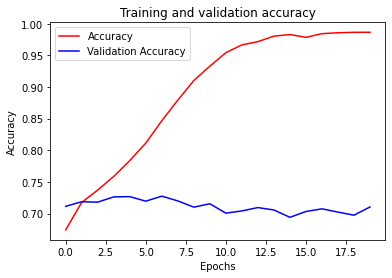

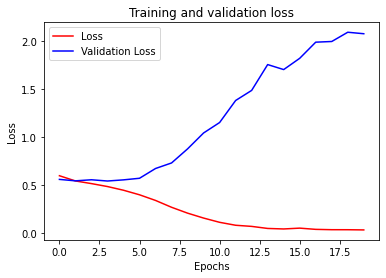

<Figure size 432x288 with 0 Axes>

In [68]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!